# Evaluating classification models

In this notebook, we will look at how to evaluate classification models in terms of the confusion matrix and measures such as accuracy, precision, and recall, as well as the ROC curve and AUC. 

We will, again, use the diabetes dataset that can be used to classify whether people have diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
diab_data = pd.read_csv('diabetes.csv')

In [3]:
diab_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cross-validation

We saw last time that there was a very large variance for the K-Nearest-Neighbor classifier, in the sense that we got very different results dependent on the train-test split (based on what number we used for `random_state`). Let us first visualize that:

In [4]:
y = diab_data["Outcome"]
X = diab_data.drop(columns = ["Age", "Outcome"])
acclist = [] 

random_seeds = np.random.randint(1000, size=50)
for seed in random_seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn5.fit(X_train, y_train)
    y_pred5_test = knn5.predict(X_test)
    acclist.append({"seed": seed, "Test accuracy": accuracy_score(y_test, y_pred5_test)})

accuracyDF = pd.DataFrame(acclist)
accuracyDF["Test accuracy"].describe()

count    50.000000
mean      0.712708
std       0.028689
min       0.645833
25%       0.697917
50%       0.713542
75%       0.723958
max       0.770833
Name: Test accuracy, dtype: float64

[]

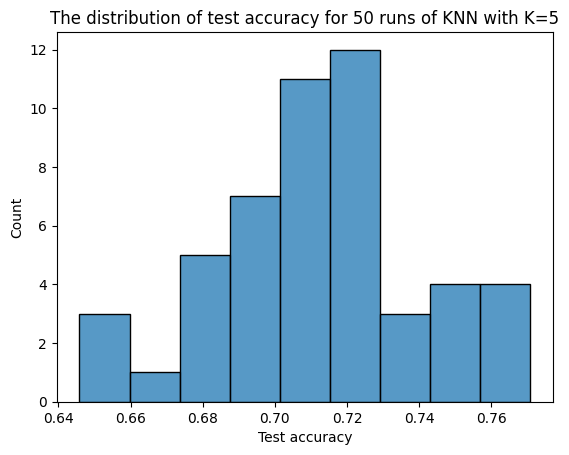

In [5]:
sns.histplot(data = accuracyDF, x = "Test accuracy")
plt.title("The distribution of test accuracy for 50 runs of KNN with K=5")
plt.plot()

Let us try to use cross-validation instead. There are multiple ways of doing this, but one is to use the `cross_val_score` from Scikit-learn model_selection module. It makes k-fold cross validation - that is, it trains k different models and evaluate the accuracy on the k hold-out folds. Note that, it only returns the accuracy scores of each fold. We should then train the model afterward on the entire set. (Strictly speaking, we should have done a train test split first and only ran the cross-validation on this training set. Then trained the model on the entire training set, and then finally evaluated the model on the untouched test set.)

In [6]:
from sklearn.model_selection import cross_val_score

knn5 = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn5, X, y, cv = 5)  # cv = 5 means 5-fold cross validation
scores

array([0.70779221, 0.66233766, 0.70779221, 0.75816993, 0.67973856])

We can then use the mean of these as an unbiased estimate of the accuracy of our model on future unseen data:

In [7]:
scores.mean()

np.float64(0.7031661149308208)

Let us try out with different K's to see how much variance we have in this estimate:

In [1]:
kacclist = [] 
for k in range(2, 20):
    scores = cross_val_score(knn5, X, y, cv = k)
    kacclist.append({"Folds": k, "Mean accuracy": scores.mean()})

kaccuracyDF = pd.DataFrame(kacclist)
kaccuracyDF["Mean accuracy"].describe()

NameError: name 'cross_val_score' is not defined

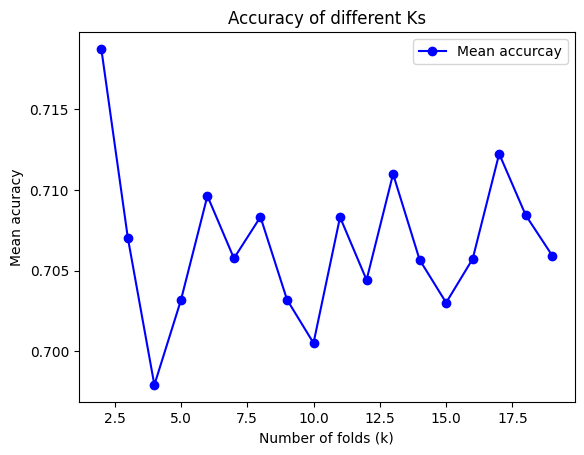

In [9]:
plt.plot(kaccuracyDF["Folds"], kaccuracyDF["Mean accuracy"], label = "Mean accurcay", color='blue', marker='o', linestyle='solid')    
plt.xlabel('Number of folds (k)')
plt.ylabel('Mean acuracy')
plt.title("Accuracy of different Ks")
plt.legend()

plt.show()

[]

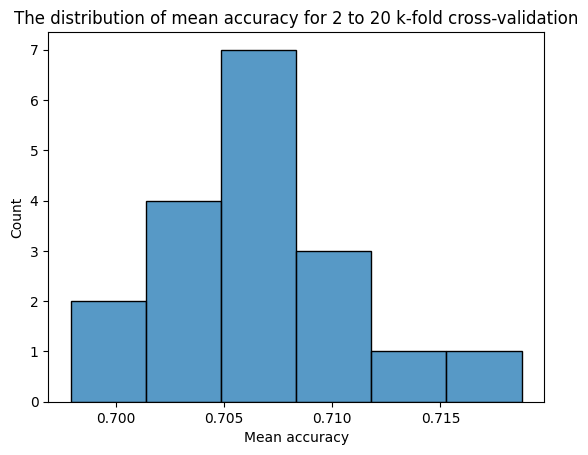

In [10]:
sns.histplot(data = kaccuracyDF, x = "Mean accuracy")
plt.title("The distribution of mean accuracy for 2 to 20 k-fold cross-validation")
plt.plot()

We can now use 5-fold cross validation to chose a $K$ for the KNN classifier:

In [11]:
def knnSweepCrossValidation(X, y, maxK, folds=5):
    kacclist = []
    
    for k in range(2, maxK):
        knn = KNeighborsClassifier(n_neighbors=k)     
        scores = cross_val_score(knn, X, y, cv = folds)
        kacclist.append({"K": k, "CV accuracy": scores.mean()})

    return pd.DataFrame(kacclist)

In [12]:
knnSweepCrossValidation(X, y, 25)

,K,CV accuracy
0,2,0.703149
1,3,0.695357
2,4,0.713547
3,5,0.703166
4,6,0.705747
5,7,0.716128
6,8,0.734386
7,9,0.725261
8,10,0.744801
9,11,0.734377


Let us compare it to the `random_state=42` from last time.

In [13]:
def knnSweep(X, y, maxK):
    accuracy_row_list = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    for k in range(2, maxK):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_test = knn.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accuracy_row_list.append({"K": k, "Random42 test accuracy": accuracy_test})

    return pd.DataFrame(accuracy_row_list)

In [14]:
ran25 = knnSweep(X, y, 25)
cv25 = knnSweepCrossValidation(X, y, 25)

compareDF = pd.merge(ran25, cv25, on="K")
compareDF.head()

,K,Random42 test accuracy,CV accuracy
0,2,0.713542,0.703149
1,3,0.635417,0.695357
2,4,0.708333,0.713547
3,5,0.682292,0.703166
4,6,0.666667,0.705747


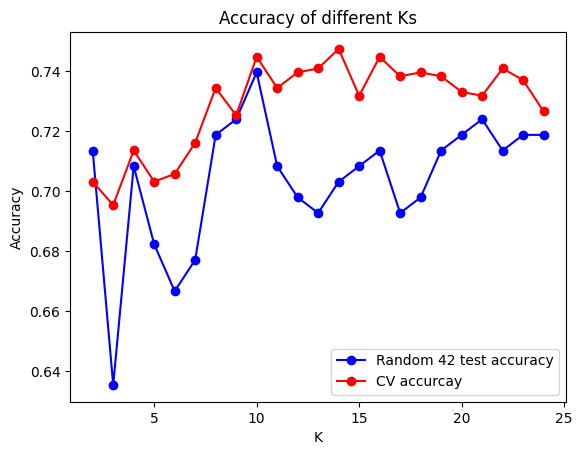

In [15]:
plt.plot(compareDF["K"], compareDF["Random42 test accuracy"], label = 'Random 42 test accuracy', color='blue', marker='o', linestyle='solid')
plt.plot(compareDF["K"], compareDF["CV accuracy"], label = 'CV accurcay', color='red', marker='o', linestyle='solid')
    
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Accuracy of different Ks")
plt.legend()

plt.show()

We clearly see much less variance in the cross-validation accuracy! There is still variation, but that is mainly due to the fact that we have a small dataset and KNN is a model type with high variance. But it looks like that $K=10$ is a sensible choice.

## The confusion matrix

we will now focus on a single model of KNN trained for $K=5$ and $K=10$:

In [16]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X, y)
y_pred5 = knn5.predict(X)

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X, y)
y_pred10 = knn10.predict(X)

We can use the `confusion_matrix` function from the Scikit-learn metrics submodule, to get a confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(y, y_pred5)

array([[448,  52],
       [ 98, 170]])

In [19]:
confusion_matrix(y, y_pred10)

array([[455,  45],
       [136, 132]])

We can also make it visually more appealing with a heatmap style plot using `ConfusionMatrixDisplay` also from Scikit-learn metrics.

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

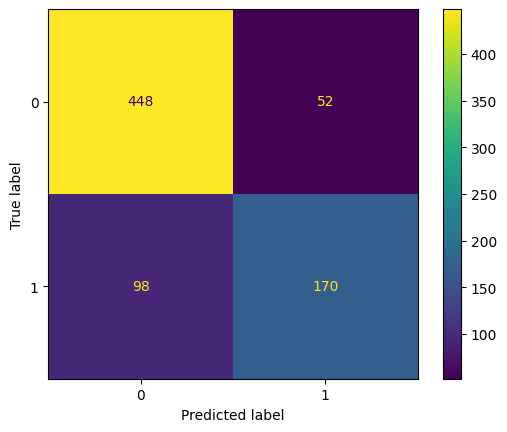

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y, y_pred5)).plot()
plt.show()

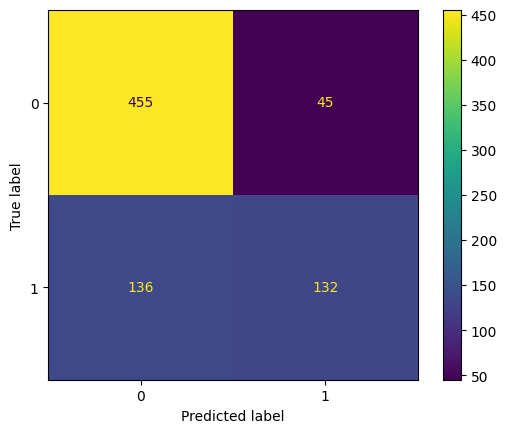

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y, y_pred10)).plot()
plt.show()

It looks like the model for $K=10$ make less False Positive predictions (45 instead of 52) than the model for $K=5$. On the other hand, it makes much more False Negative predictions (136 instead of 98). So the $K=10$ model does not seem much better than the $K=5$ model. Let us calculate the various metrics to make a more detailed comparison.

If one wants to look at percentages instead, we can normalize the values in the cells to sum to one:

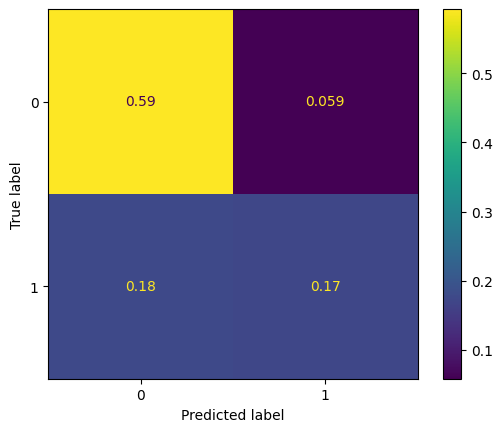

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y, y_pred10, normalize='all')).plot()
plt.show()

## Evaluation metrics

We can import all the revelant evaluation metrics from Scikit-learn metrics submodule:

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [25]:
EvaluationScoreDF = pd.DataFrame({"K": [5, 10],
                                  "Accuracy": [accuracy_score(y, y_pred5), accuracy_score(y, y_pred10)],
                                  "Precision": [precision_score(y, y_pred5), precision_score(y, y_pred10)],
                                  "Recall": [recall_score(y, y_pred5), recall_score(y, y_pred10)],
                                  "F1": [f1_score(y, y_pred5), f1_score(y, y_pred10)]})
EvaluationScoreDF                            

,K,Accuracy,Precision,Recall,F1
0,5,0.804688,0.765766,0.634328,0.693878
1,10,0.764323,0.745763,0.492537,0.593258


We see that the $K=5$ actually seems to perform better on all metrics.

## ROC and AUC evaluation

We will not look at the ROC curve and calculate AUC for the models. For this we will use our logistic regression model from last time as it naturally can give us class probabilities instead hard labels.

In [26]:
from sklearn import linear_model

In [27]:
logit_model = linear_model.LogisticRegression()

In [28]:
X = diab_data[["Glucose", "BMI"]]  

In [29]:
logit_model.fit(X, y)

LogisticRegression()

We want to get the class probabilities (of class 1). We can use the method `.predict_proba` on the logistic model object:

In [30]:
logit_model.predict_proba(X)

array([[0.43679195, 0.56320805],
       [0.92384478, 0.07615522],
       [0.33206106, 0.66793894],
       ...,
       [0.77906494, 0.22093506],
       [0.68711916, 0.31288084],
       [0.8726235 , 0.1273765 ]])

Note how it returns two columns of probabilities! The first column is the probability of class 0, while the second column is the probabilities of class 1 (note how the rows sum to 1). Thus, to get the probabilities for class 1, we can take the second column (denoted 1 in Python - I think I mixed it up last time):

In [31]:
y_probs = logit_model.predict_proba(X)[:,1]
y_pred = logit_model.predict(X)

y_probs

array([0.56320805, 0.07615522, 0.66793894, 0.09616368, 0.64393679,
       0.18514527, 0.08270949, 0.31505006, 0.85079302, 0.04231174,
       0.3149897 , 0.78472735, 0.36389748, 0.80673779, 0.57244622,
       0.15333136, 0.53254938, 0.183463  , 0.35709815, 0.30363517,
       0.4789056 , 0.20888125, 0.91800589, 0.24659926, 0.57623708,
       0.32179786, 0.65965359, 0.08840442, 0.32706208, 0.31048018,
       0.28207451, 0.61140352, 0.07394157, 0.05946755, 0.2463469 ,
       0.112926  , 0.46803637, 0.19513129, 0.19240299, 0.31434332,
       0.80378606, 0.55735966, 0.11355607, 0.87694327, 0.54184903,
       0.88296229, 0.47157028, 0.05308732, 0.28729107, 0.02139786,
       0.08223771, 0.1075258 , 0.07187786, 0.77670251, 0.60072704,
       0.03944542, 0.87421354, 0.39500431, 0.67052215, 0.34185425,
       0.01033961, 0.41902602, 0.01695947, 0.35025582, 0.26842781,
       0.13940877, 0.23123377, 0.39585463, 0.0642595 , 0.45638425,
       0.18432068, 0.39079087, 0.55688635, 0.42567554, 0.09157

To plot the ROC curve, we well use the `roc_curve` from Scikit-learn metrics to calculate the FPR and TPR for us that we can then plot

In [32]:
from sklearn.metrics import roc_curve, auc

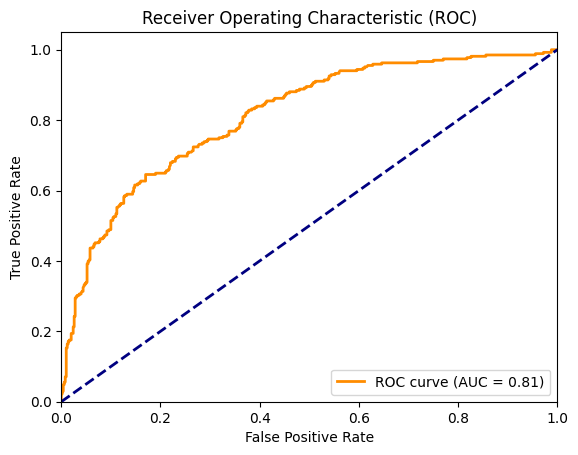

In [33]:
# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

We can also get the AUC directly using the `roc_auc_score` function from Scikit-learn:

In [34]:
from sklearn.metrics import roc_auc_score

In [35]:
roc_auc_score(y, y_probs)

np.float64(0.8109328358208956)